# TSLA Price & Sentiment — Forecasting Notebook  
_load → model → visualize_

#### Imports

In [ ]:
# !pip install yfinance requests python-dotenv tqdm tensorflow scikit-learn scipy matplotlib
import subprocess
import sys

packages = [
    "yfinance",
    "requests",
    "python-dotenv",
    "tqdm",
    "tensorflow==2.19.0",
    "scikit-learn",
    "scipy",
    "matplotlib"
]

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

import os, time, requests, datetime as dt

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
from dotenv import load_dotenv
from scipy.stats import linregress
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




## Phase 1 – Loading the data
### 1.1  Download TSLA OHLCV from Yahoo Finance

In [3]:
ticker, start, end = "TSLA", "2010-06-29", "2025-05-08"
tsla_df = yf.download(
    ticker,
    start=start,
    end=end,
    auto_adjust=False,      # keep real OHLC
    group_by="column",
    progress=False
)
# flatten any rare MultiIndex coming from yfinance
if isinstance(tsla_df.columns, pd.MultiIndex):
    tsla_df.columns = tsla_df.columns.get_level_values(0)

tsla_df.index.name = "Date"
print(tsla_df.head()), print(tsla_df.tail())

# persist a clean copy
tsla_df.to_csv("tsla_ohlcv.csv")
print("✅ Clean CSV written to tsla_ohlcv.csv | shape:", tsla_df.shape)


Price       Adj Close     Close      High       Low      Open     Volume
Date                                                                    
2010-06-29   1.592667  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30   1.588667  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01   1.464000  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02   1.280000  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06   1.074000  1.074000  1.333333  1.055333  1.333333  103003500
Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2025-05-01  280.519989  280.519989  290.869995  279.809998  280.010010   
2025-05-02  287.209991  287.209991  294.779999  279.809998  284.899994   
2025-05-05  280.260010  280.260010  284.850006  274.399994  284.570007   
2025-05-06  275.350006  275.350006  277.730011  271.350006  273.109985   
2025-05-07  276.220001  276.220001  277.92001

### 1.2  Grab the last-90-days of TSLA social-sentiment (Financial Modeling Prep)


In [8]:
API_KEY = "fPgEFbj0X9Arf9NpyqWRLWfuj2RpLPUm"

START = dt.datetime(2025, 2, 7)            # inclusive
TICKER = "TSLA"
URL = ("https://financialmodelingprep.com/api/v4/historical/social-sentiment"
       "?symbol={sym}&page={pg}&apikey=" + API_KEY)

# ── helper to fetch one ticker, page-by-page ──────────────────────────────
def fetch_tsla():
    page, rows = 0, []
    while True:
        js = requests.get(URL.format(sym=TICKER, pg=page), timeout=30).json()
        if not js:
            break
        for r in js:
            ts = dt.datetime.strptime(r["date"], "%Y-%m-%d %H:%M:%S")
            if ts < START:                # done with window
                return rows
            r["datetime"] = ts.replace(minute=0, second=0, microsecond=0)
            rows.append(r)
        page += 1
        time.sleep(0.05)                  # 20 req/s  ≈ 300 req/min limit
    return rows


print("⏳  Downloading hourly TSLA sentiment …")
rows = fetch_tsla()
print(f"✅  Pulled {len(rows):,} rows")


⏳  Downloading hourly TSLA sentiment …
✅  Pulled 2,168 rows


In [9]:
# ── DataFrame & tidy column names ────────────────────────────────────────
df_hourly = pd.DataFrame(rows).rename(columns={
    "symbol":              "ticker",
    "stocktwitsPosts":     "sw_posts",
    "twitterPosts":        "tw_posts",
    "stocktwitsSentiment": "sw_sent",
    "twitterSentiment":    "tw_sent",
    "stocktwitsComments":  "sw_comments",
    "twitterComments":     "tw_comments",
    "stocktwitsLikes":     "sw_likes",
    "twitterLikes":        "tw_likes",
    "stocktwitsImpressions": "sw_impressions",
    "twitterImpressions":    "tw_impressions",
})

# ── save raw hourly CSV ─────────────────────────────────────────────────
df_hourly.to_csv("tsla_sentiment_hourly.csv", index=False)
print("📝  Wrote tsla_sentiment_hourly.csv")

📝  Wrote tsla_sentiment_hourly.csv


In [10]:
# ── aggregate to daily averages ─────────────────────────────────────────
df_hourly["date"] = df_hourly["datetime"].dt.date
daily = (
    df_hourly
      .groupby("date")[["sw_sent", "tw_sent", "sw_posts", "tw_posts", "tw_impressions", "sw_impressions"]]
      .mean()
      .reset_index()
      .rename(columns={"date": "Date",
                       "sw_sent": "SW_Sentiment",
                       "tw_sent": "TW_Sentiment",
                       "sw_posts": "SW_Posts",
                       "tw_posts": "TW_Posts",
                       "tw_impressions": "TW_Impressions",
                       "sw_impressions": "SW_Impressions",})
)

daily.to_csv("tsla_sentiment_90d.csv", index=False)
print("📝  Wrote tsla_sentiment_90d.csv  (daily averages)")

# ── keep DataFrames in memory for notebook use ──────────────────────────
print("\nDataFrames ready:")
print(" • df_hourly → hourly sentiment   shape:", df_hourly.shape)
print(" • daily      → daily  sentiment   shape:", daily.shape)

📝  Wrote tsla_sentiment_90d.csv  (daily averages)

DataFrames ready:
 • df_hourly → hourly sentiment   shape: (2168, 13)
 • daily      → daily  sentiment   shape: (90, 7)


### 1.3 Reload clean CSVs and build a single `full_df`

In [11]:
# reload OHLCV (safe + single-level index)
tsla_df = (
    pd.read_csv("tsla_ohlcv.csv", parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)

# reload sentiment
sent_df = (
    pd.read_csv("tsla_sentiment_90d.csv", parse_dates=["Date"])
      .set_index("Date")
)

full_df = tsla_df.join(sent_df, how="left").fillna(0)
print(full_df.tail())


             Adj Close       Close        High         Low        Open  \
Date                                                                     
2025-05-01  280.519989  280.519989  290.869995  279.809998  280.010010   
2025-05-02  287.209991  287.209991  294.779999  279.809998  284.899994   
2025-05-05  280.260010  280.260010  284.850006  274.399994  284.570007   
2025-05-06  275.350006  275.350006  277.730011  271.350006  273.109985   
2025-05-07  276.220001  276.220001  277.920013  271.000000  276.880005   

               Volume  SW_Sentiment  TW_Sentiment    SW_Posts    TW_Posts  \
Date                                                                        
2025-05-01   99659000      0.516733      0.527484  101.400000  218.320000   
2025-05-02  114454700      0.524943      0.556143   88.458333  186.833333   
2025-05-05   94618900      0.528652      0.544127   72.958333  156.458333   
2025-05-06   76715800      0.521266      0.540108   87.400000  191.800000   
2025-05-07   718824

## Phase 2 – Exploratory Data Analysis (EDA)  
#### What is the relationship between sentiment and stock price?
### 2.1  TSLA Close vs. Twitter sentiment (raw & weighted)


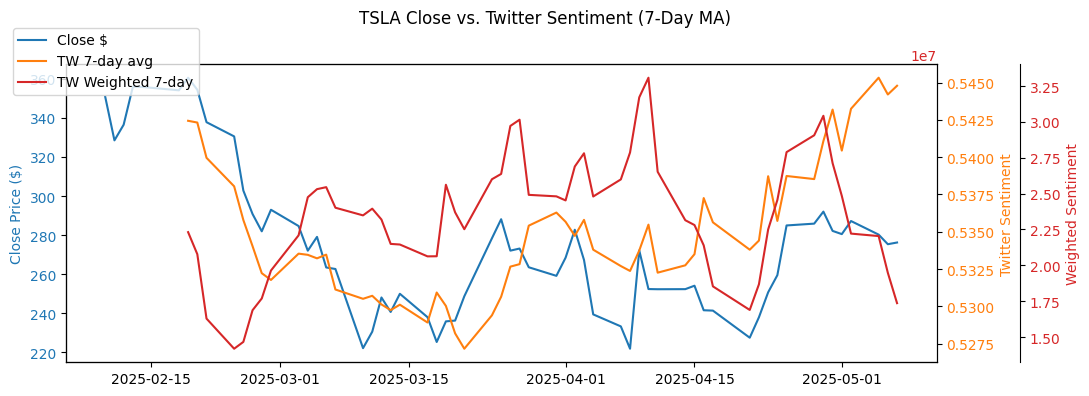

In [12]:

# 1. limit to sentiment window
start_sent, end_sent = "2025-02-09", "2025-05-09"
df = full_df.loc[start_sent : end_sent].copy()

# 2. build weighted-Twitter sentiment (sentiment × impressions)
df["TW_Weighted"] = df["TW_Sentiment"] * df["TW_Impressions"]

# 3. 7-day moving-average smooth
roll = df[["TW_Sentiment", "TW_Weighted"]].rolling(7).mean()

# 4. PLOT: three y-axes
fig, ax_price = plt.subplots(figsize=(11,4))

# primary y-axis → Close price
ax_price.plot(df.index, df["Close"], color="tab:blue", label="Close $")
ax_price.set_ylabel("Close Price ($)", color="tab:blue")
ax_price.tick_params(axis="y", labelcolor="tab:blue")

# secondary y-axis → raw Twitter sentiment
ax_sent = ax_price.twinx()
ax_sent.plot(roll.index, roll["TW_Sentiment"],
             color="tab:orange", label="TW 7-day avg")
ax_sent.set_ylabel("Twitter Sentiment", color="tab:orange")
ax_sent.tick_params(axis="y", labelcolor="tab:orange")

# third y-axis (shifted outward) → weighted sentiment
ax_weight = ax_price.twinx()
ax_weight.spines.right.set_position(("outward", 60))
ax_weight.plot(roll.index, roll["TW_Weighted"],
               color="tab:red", label="TW Weighted 7-day")
ax_weight.set_ylabel("Weighted Sentiment", color="tab:red")
ax_weight.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("TSLA Close vs. Twitter Sentiment (7-Day MA)")
fig.tight_layout()
lines, labels = [], []
for ax in (ax_price, ax_sent, ax_weight):
    L, lab = ax.get_legend_handles_labels()
    lines += L; labels += lab
fig.legend(lines, labels, loc="upper left", bbox_to_anchor=(0.01,0.95))
plt.show()


It's evident that unweighted twitter sentiment has a high correlation with close prices

## Phase 3 – Creating the model  
### (Baseline LSTM vs LSTM + Sentiment)


### 3.1 Feature engineering & scaling  

In [ ]:
start_sent, end_sent = "2025-02-09", "2025-05-09"
look_back = 60

end_date   = pd.Timestamp(end_sent)
start_hist = end_date - pd.DateOffset(years=15)     # training history
sent_start = pd.Timestamp(start_sent)

df = full_df.loc[start_hist:end_date, ["Close", "TW_Sentiment"]].copy()

# z-score the Close column
sc_close = StandardScaler().fit(df["Close"].values.reshape(-1,1))

# z-score sentiment, but fit only on the period that actually has data
sc_sent = StandardScaler().fit(
    df.loc[sent_start:, "TW_Sentiment"].values.reshape(-1,1)
)

close_scaled = sc_close.transform(df["Close"].values.reshape(-1,1)).ravel()

# sentiment = 0 (mean) outside its window
sent_scaled  = np.zeros_like(close_scaled, dtype="float32")
mask_sent = df.index >= sent_start
sent_scaled[mask_sent] = sc_sent.transform(
    df.loc[mask_sent, "TW_Sentiment"].values.reshape(-1,1)
).ravel()

mat_close = close_scaled.reshape(-1,1)                        # 1-feature
mat_both  = np.column_stack([close_scaled, sent_scaled])      # 2-feature


### 3.2 Rolling windows helper  

In [ ]:
def make_xy(mat):
    """Convert a 2-D matrix into (X, y) using a sliding window."""
    x, y = [], []
    for i in range(look_back, len(mat)):
        x.append(mat[i-look_back:i])
        y.append(mat[i, 0])           # predict the scaled Close
    return np.array(x), np.array(y)

x0, y  = make_xy(mat_close)
x1, _  = make_xy(mat_both)


### 3.3 Train/test split (last 90 days) 

In [ ]:
test_mask  = (df.index[look_back:] >= sent_start)
train_mask = ~test_mask

x0_tr, y_tr = x0[train_mask], y[train_mask]
x0_te, y_te = x0[test_mask],  y[test_mask]
x1_tr = x1[train_mask]
x1_te = x1[test_mask]


### 3.4 LSTM builder  

In [ ]:
def build_lstm(n_feat):
    m = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True,
                             input_shape=(look_back, n_feat)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(25, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


### 3.5 Train baseline (Close only no sentiment)

In [ ]:
mdl0 = build_lstm(1)
mdl0.fit(
    x0_tr, y_tr, epochs=10, batch_size=32,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3,
                                                restore_best_weights=True)],
    verbose=0
)
pred0 = sc_close.inverse_transform(
    mdl0.predict(x0_te, verbose=0)
).ravel()


### 3.6 Train Close + Sentiment model

In [ ]:
mdl1 = build_lstm(2)
mdl1.fit(
    x1_tr, y_tr, epochs=10, batch_size=32,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3,
                                                restore_best_weights=True)],
    verbose=0
)
pred1 = sc_close.inverse_transform(
    mdl1.predict(x1_te, verbose=0)
).ravel()

true_close = sc_close.inverse_transform(y_te.reshape(-1,1)).ravel()


/Users/rishi/cs439test/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3.7 Metrics side-by-side 

In [ ]:
def stats(t, p):
    return dict(
        RMSE = np.sqrt(mean_squared_error(t, p)),
        MAE  = mean_absolute_error(t, p),
        MAPE = np.mean(np.abs((t-p)/t))*100,
        R2   = r2_score(t, p)
    )

m0 = stats(true_close, pred0)
m1 = stats(true_close, pred1)

print("\n=== Performance on last 90 trading days ===")
for k in m0:
    diff = m0[k]-m1[k] if k!="R2" else m1[k]-m0[k]   
    print(f"{k:<6} Close-only: {m0[k]:6.2f}  +Sent: {m1[k]:6.2f}  "
          f"{'improved' if diff>0 else 'worse' if diff<0 else 'same'} "
          f"by {abs(diff):.2f}")



=== Performance on last 90 trading days ===
RMSE   Close-only:  20.70  +Sent:  19.48  improved by 1.21
MAE    Close-only:  16.81  +Sent:  15.64  improved by 1.17
MAPE   Close-only:   6.23  +Sent:   5.76  improved by 0.47
R2     Close-only:   0.69  +Sent:   0.73  improved by 0.03


## Phase 4 – Visualizing the results
### 4.1 Predictions vs True Close (last 90 trading days)


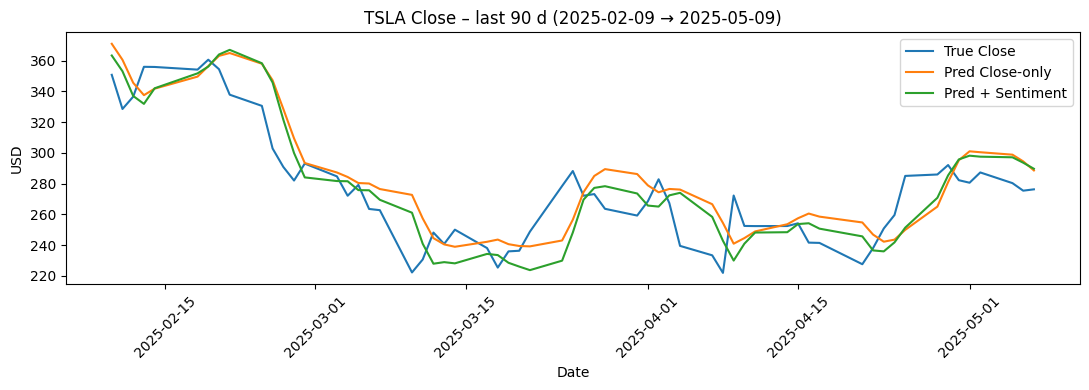

In [22]:
dates_test = df.index[look_back:][test_mask]
plt.figure(figsize=(11,4))
plt.plot(dates_test, true_close, label="True Close")
plt.plot(dates_test, pred0,     label="Pred Close-only")
plt.plot(dates_test, pred1,     label="Pred + Sentiment")
plt.title("TSLA Close – last 90 d (2025-02-09 → 2025-05-09)")
plt.xlabel("Date"); plt.ylabel("USD"); plt.xticks(rotation=45)
plt.legend(); plt.tight_layout(); plt.show()


### 4.2 Residual histogram + quick numeric metrics


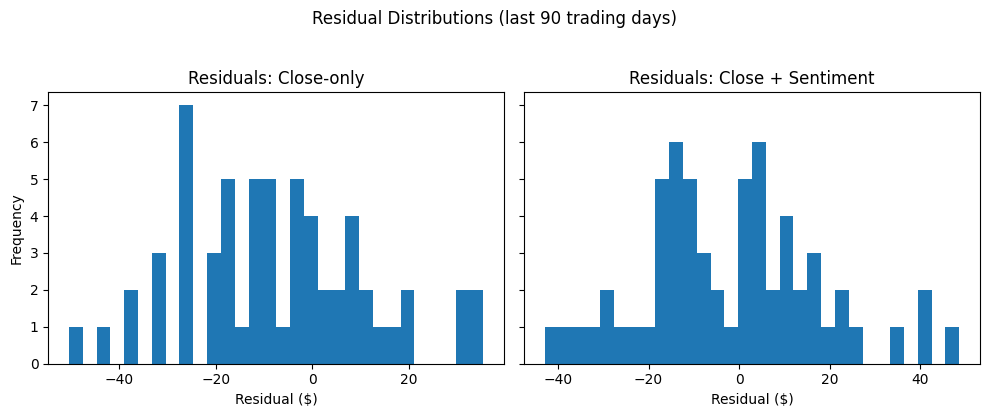

In [24]:
# pick the true y once
true = true_close                       # already inverse-scaled earlier

# residual vectors
res0 = true - pred0                     # Close-only model
res1 = true - pred1                     # Close + Sentiment model

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)

# --- subplot A: Close-only ---
axes[0].hist(res0, bins=30)
axes[0].set_title("Residuals: Close-only")
axes[0].set_xlabel("Residual ($)")
axes[0].set_ylabel("Frequency")

# --- subplot B: Close + Sentiment ---
axes[1].hist(res1, bins=30)
axes[1].set_title("Residuals: Close + Sentiment")
axes[1].set_xlabel("Residual ($)")

plt.suptitle("Residual Distributions (last 90 trading days)", y=1.03, fontsize=12)
plt.show()


In [ ]:
def residual_stats(residuals):
    """Return mean, std, MAE, and RMSE for a 1-D residual array."""
    return pd.Series({
        "mean": residuals.mean(),
        "std" : residuals.std(),
        "MAE" : np.mean(np.abs(residuals)),
        "RMSE": np.sqrt(np.mean(residuals**2))
    })

stats = pd.concat(
    [residual_stats(res0), residual_stats(res1)],
    axis=1,
    keys=["Close-only", "Close + Sent"]
).T

print("\nResidual-level statistics (lower is better except |mean| close to 0):")
display(stats.round(3))      


Residual-level statistics (lower is better except |mean| close to 0):


,mean,std,MAE,RMSE
Close-only,-7.765,19.184,16.812,20.696
Close + Sent,-1.715,19.407,15.644,19.483
